### To do:
1. Make grid search
2. Test balanced and unbalanced dataset
3. CNN-LIN
4. RNN/LSTM
5. MDN

### Results

    Lin bench
        Tanh/Relu
        Layers     n_hidden
             5          100    - Decreased accuracy (marginal)
             5           50    - Decent accuracy
             5           25    - Decent accuracy
             5           10    - Decreased accuracy (drastic, esp w/ RELU)

         Optimal
             3           25
         

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path

# Data processing
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.blocks import StdLinear, StdConv, DenseBlock
from utils.clr import *
from collections import OrderedDict

In [43]:
use_cuda = torch.cuda.is_available(); print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
CUDA_LAUNCH_BLOCKING=1
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Model vars
bs = 10                        # 1 for linbench
md = False

True


## Data Ingest

In [3]:
DATAPATH = Path.cwd() / 'data'

In [4]:
def moving_mean(time, data, lag=5):
    X = []
    y = []
    y_std = []
    for i in range(int(len(data)/lag)):
        X.append(time[(i*lag+lag)])
        y.append(np.mean(data[(i*lag):(i*lag+lag)]))
        y_std.append(np.std(data[(i*lag):(i*lag+lag)]))
        
    return X, y, y_std

In [5]:
df = pd.read_csv(DATAPATH / 'dual_sen_sample_1.csv',parse_dates=['datetime','date'])

df.drop(['date','time','r_sen_1','s_sen_1','s_sen_2'],axis=1,inplace=True)
# df["mvg20_sen_2"] = df.loc[:,"r_sen_2"].rolling(window=20).mean()
# df["mvg20_sen_2"] = df["mvg20_sen_2"].round()
df['r_sen_2'] = (df['r_sen_2'] - 630)*-1
x, y, y_err = moving_mean(df['datetime'],df["r_sen_2"], 10)
df.loc[df['datetime'].isin(x),'avg_sen_2'] = y
df.loc[df['datetime'].isin(x),'std_sen_2'] = y_err
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

df.to_feather(DATAPATH / 'sen_aggre.feather')
df.head()
df = pd.read_feather(DATAPATH / 'sen_aggre.feather')

## Data visual

In [6]:
df_w = df.loc[df['std_sen_2'] > 15]
df_t = pd.DataFrame(data={'datetime':pd.to_datetime("2020-08-07 13:40:31"),'r_sen_2':np.average(df_w['r_sen_2']), 'avg_sen_2':np.average(df_w['avg_sen_2']),'std_sen_2':np.average(df_w['std_sen_2'])},index=[0])
df_t = df_t.append(df_w)
df_t.sort_values(['datetime'],ascending=False,inplace=True)


for r_i, r_d in df.iterrows():
    for idx, row in df_t.iterrows():
        if r_d.datetime >= row.datetime:
            df.loc[r_i,'last_water'] = r_d.datetime - row.datetime
            break
        else:
            next

df['dow'] = df.datetime.dt.dayofweek
df.reset_index(inplace=True)
df.index = df.datetime
df.drop("datetime",axis=1,inplace=True)
df.dropna(inplace=True)
df_w

,datetime,r_sen_2,avg_sen_2,std_sen_2
597,2020-08-16 18:28:31,202,112.6,113.558091
2152,2020-08-27 13:27:31,154,184.0,23.383755
3572,2020-09-06 10:01:53,210,113.6,114.248151
4738,2020-09-14 12:13:49,251,29.9,89.700000


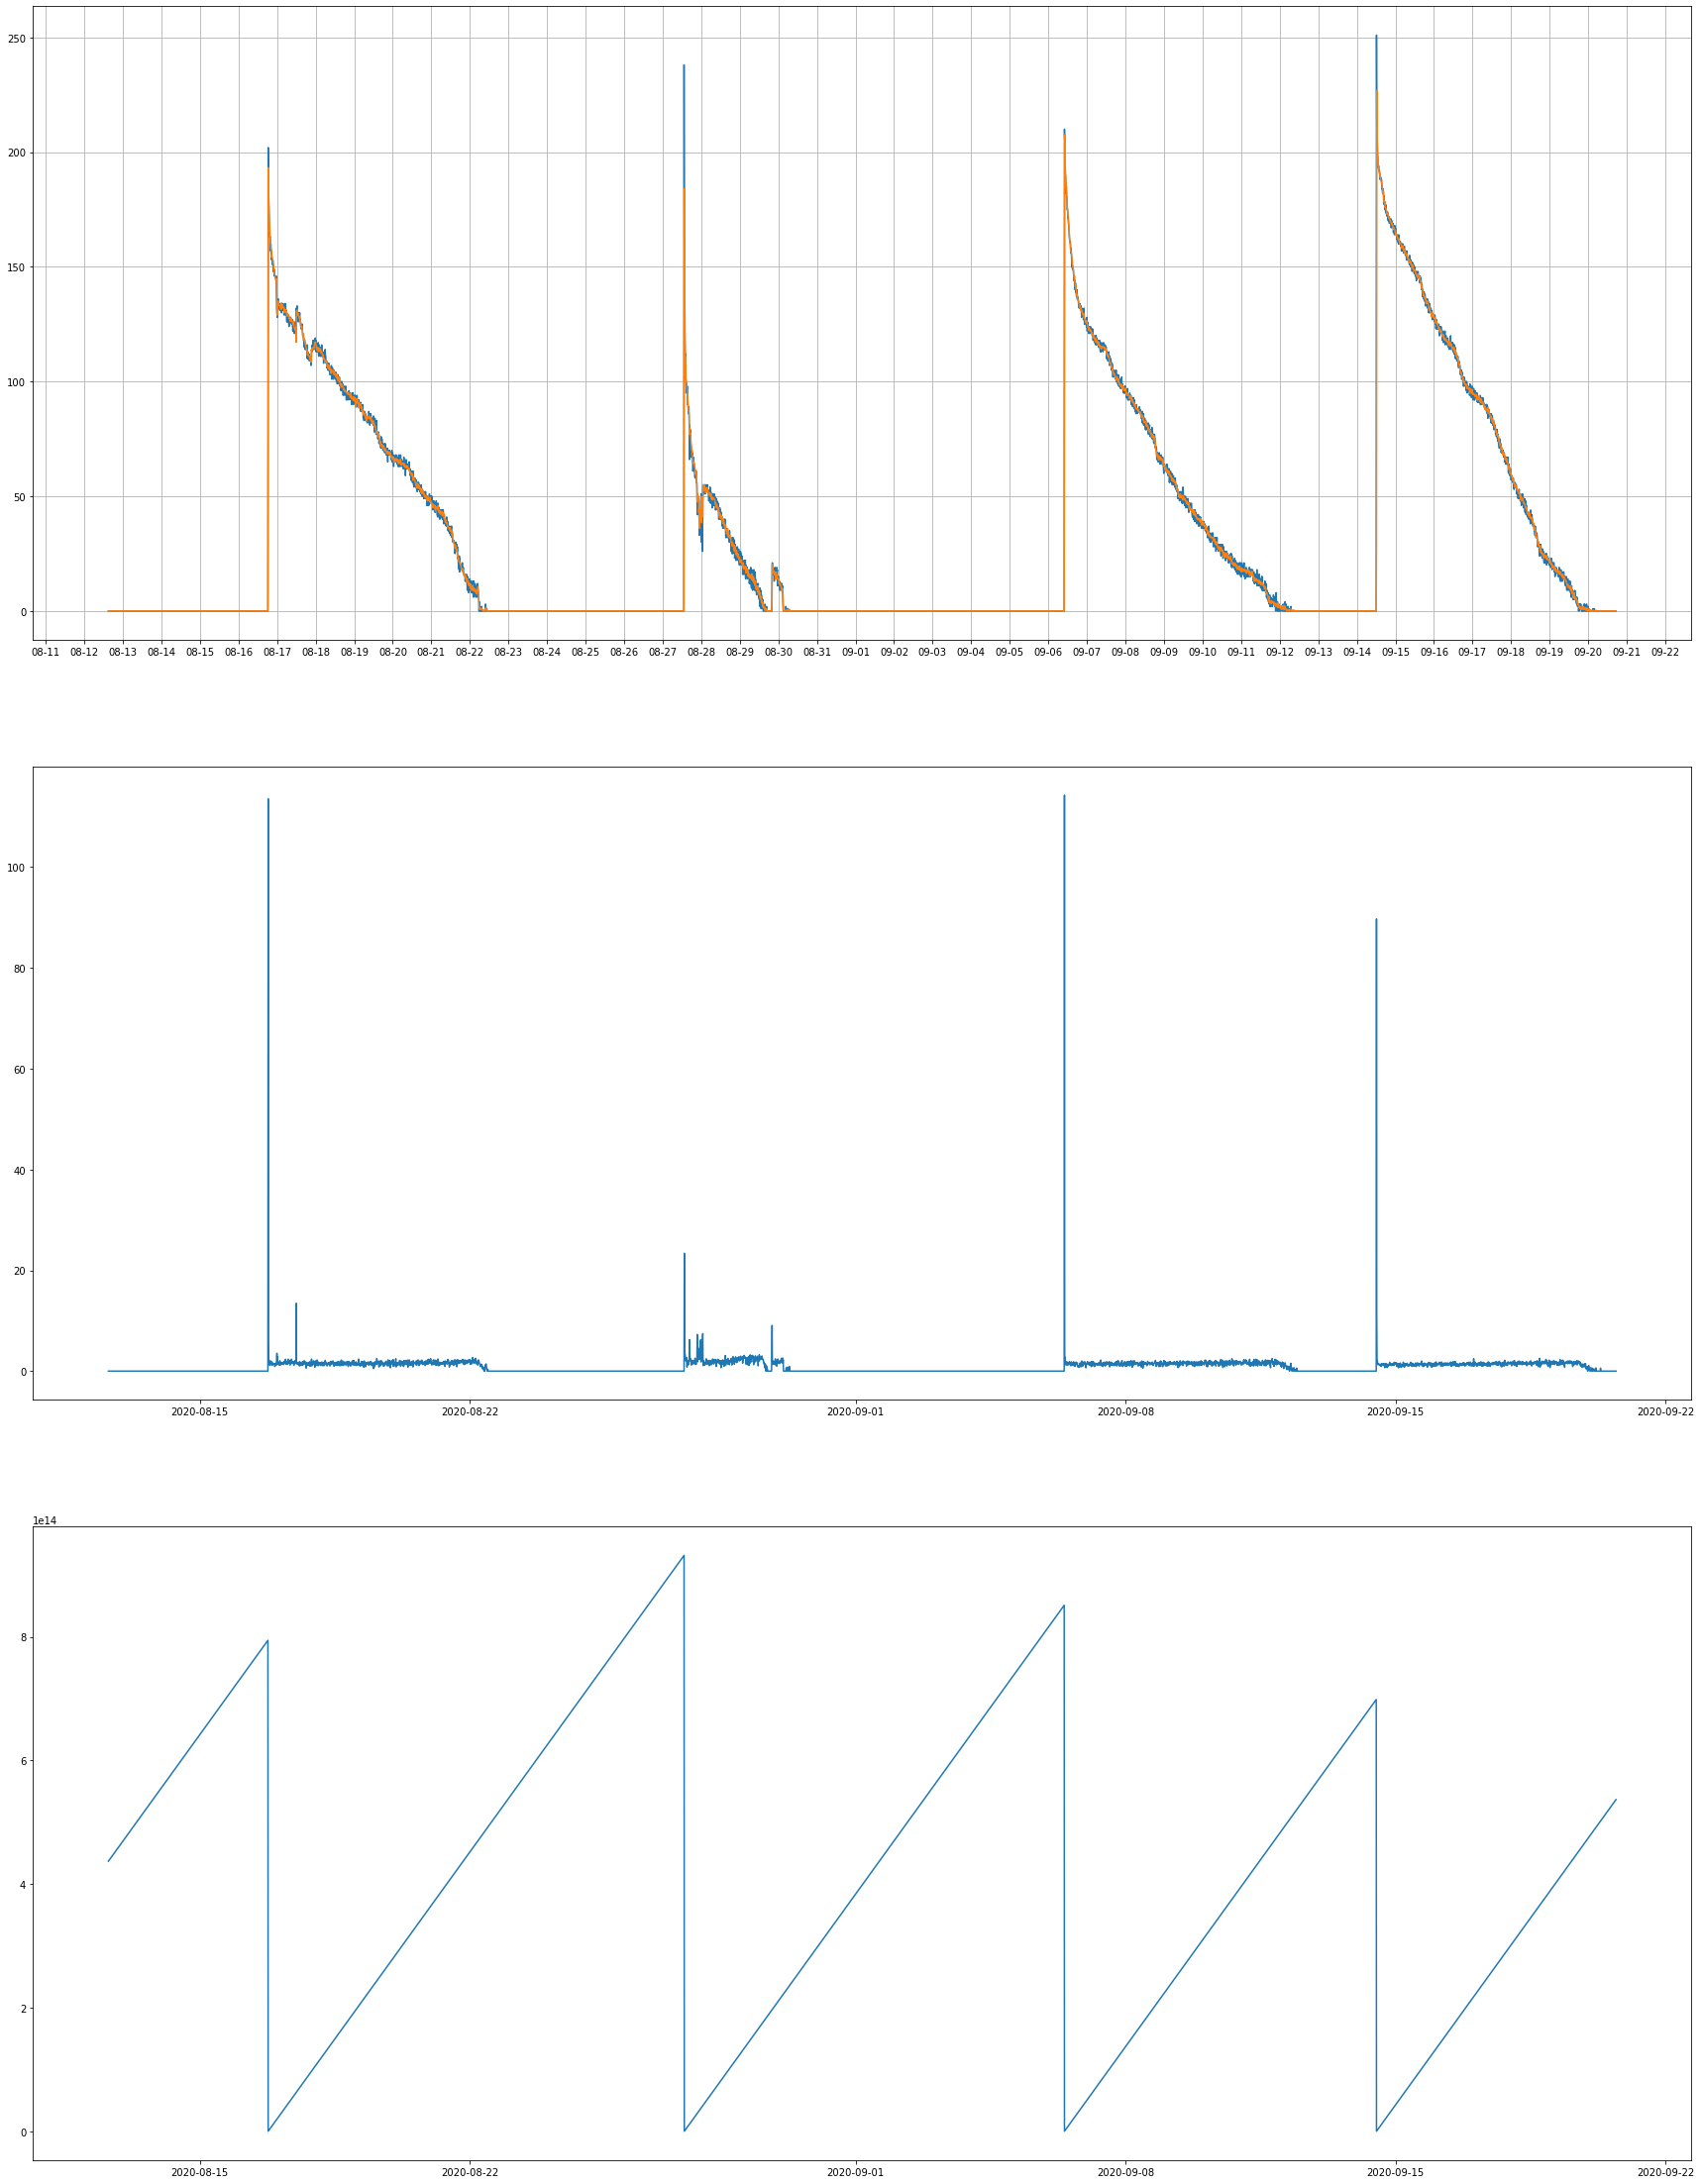

In [7]:
df_ts = df.copy()

fig, ax = plt.subplots(3,figsize=[30,40])
ax[0].grid(True)
ax[0].plot(df_ts.loc[:,'r_sen_2'],label='data')
ax[0].plot(df_ts.loc[:,'avg_sen_2'],label='avgd')
ax[0].xaxis.set_major_locator(mdates.DayLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))

ax[1].plot(df_ts['std_sen_2'])
ax[2].plot(df_ts['last_water'])
plt.show()

/opt/conda/envs/fastai/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


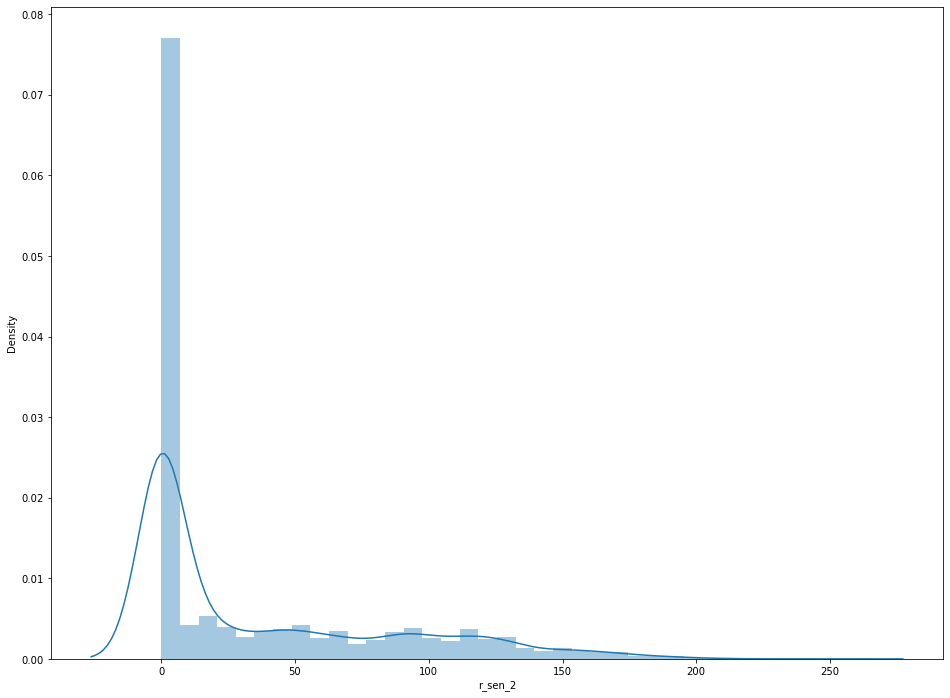

In [8]:
fig, ax = plt.subplots(figsize=(16,12))
sns.distplot(df['r_sen_2'], hist=True,ax=ax)
plt.show()

In [9]:
df_t = df.loc[df['std_sen_2'] == 0,:]
df_p = df_t.iloc[::75]
# df_p = df_t.loc[df_t['std_sen_2'].isin(df_p.loc[:,'std_sen_2']),:]
df_t = df.loc[df['std_sen_2'] > 0, :]

df_d = df_p.append(df_t)
df_d.sort_index(inplace=True)
print(len(df))
print(len(df_d))

5634
2889


In [10]:
print(len(df_t))
print(len(df_p))

2851
38


In [11]:
df_d = df_d.reset_index()
df_d.drop(['index'],axis=1,inplace=True)
df_d.to_csv(DATAPATH / 'sen_aggre2.csv')

In [12]:
df_d.head()

,datetime,r_sen_2,avg_sen_2,std_sen_2,last_water,dow
0,2020-08-12 15:02:11,0,0.0,0.0,5 days 01:21:40,2
1,2020-08-13 03:31:27,0,0.0,0.0,5 days 13:50:56,3
2,2020-08-13 16:01:27,0,0.0,0.0,6 days 02:20:56,3
3,2020-08-14 04:30:43,0,0.0,0.0,6 days 14:50:12,4
4,2020-08-14 16:59:59,0,0.0,0.0,7 days 03:19:28,4


/opt/conda/envs/fastai/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


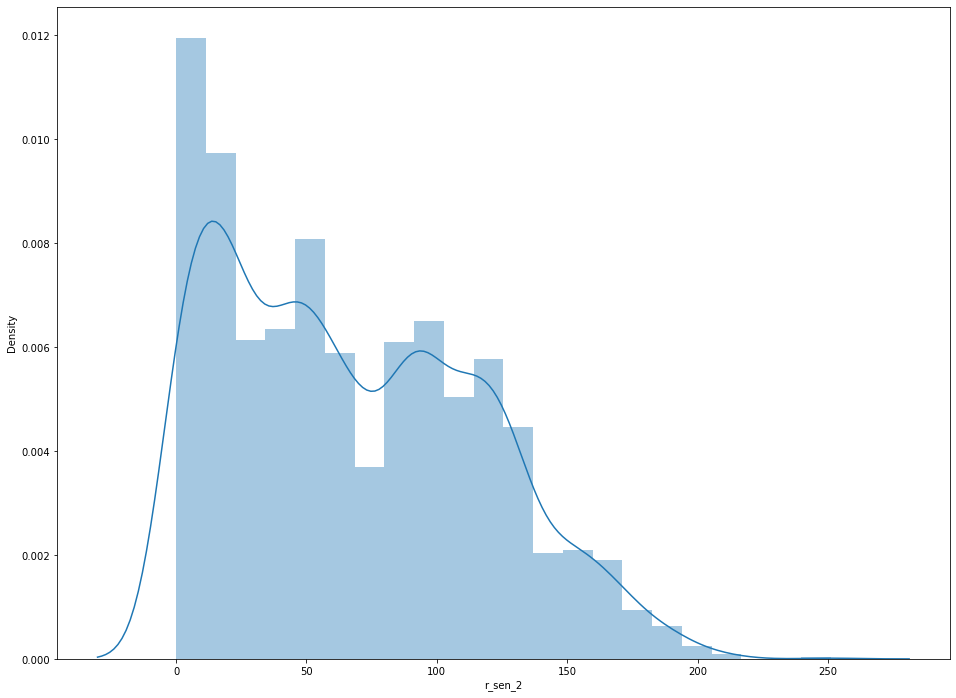

In [13]:
fig, ax = plt.subplots(figsize=(16,12))
sns.distplot(df_d['r_sen_2'], hist=True,ax=ax)
plt.show()

## Data processing

In [14]:
def ds_make(df,y_col,win=20,md=False):    
    x, y = [], []
    for i in range(int(len(df)-win-1)):
        a = df.loc[i:(i+win)-1]
        x.append(a)
        if md:
            y.append(df.loc[i+win,['avg_sen_2','std_sen_2']])
        else:
            y.append([df.loc[i+win,'avg_sen_2']])
    return np.array(x), np.array(y)

In [15]:
df_d.drop(['datetime'],axis=1,inplace=True)

df_d.loc[:,'last_water'] = df_d.loc[:,'last_water'].astype(int)/10000000000

#scale down for computing
scaler = MinMaxScaler(feature_range=(0,1))
for col in ['r_sen_2','avg_sen_2','std_sen_2','last_water','dow']:
    df_d.loc[:,col] = scaler.fit_transform(df_d[col].values.reshape(-1,1))

df_d.to_feather(DATAPATH / 'sen_aggre_final.feather')    
df_d.head()

,r_sen_2,avg_sen_2,std_sen_2,last_water,dow
0,0.0,0.0,0.0,0.487403,0.333333
1,0.0,0.0,0.0,0.537555,0.500000
2,0.0,0.0,0.0,0.587757,0.500000
3,0.0,0.0,0.0,0.637910,0.666667
4,0.0,0.0,0.0,0.688062,0.666667


## Data loader

In [128]:
class Dataset(Dataset):
    def __init__(self, data, labels):
#         super().__init__()
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [129]:
df_d = pd.read_feather(DATAPATH / 'sen_aggre_final.feather')

# split into DL data
win = 10
xs, ys = ds_make(df_d,"r_sen_2",win=win,md=md)
xs_t = []
for lookback in xs:
    xs_o = []
    for obs in lookback:
        for item in obs:
            xs_o.append(item)
    xs_t.append(xs_o)

In [130]:
trn_x, val_x, trn_y, val_y = train_test_split(xs,ys, test_size=0.2)

In [131]:
trn_ds = Dataset(trn_x, trn_y)
val_ds = Dataset(val_x, val_y)

trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True,drop_last=True)
val_dl = DataLoader(val_ds, batch_size=bs,drop_last=True)

## Model

In [54]:
def append_stats(ep_vals, epoch, values, decimals=6):
    ep_vals[epoch]=list(np.round(values, decimals))
    return ep_vals

def print_stats(epoch, values, decimals=3):
    layout = "{!s:^10}" + " {!s:10.7}" * len(values)
    values = [epoch,*values] 
    print(layout.format(*values))

def save_checkpoint(name, filename, is_best):
    state = {'epoch': epochs,
            'last_epoch': epoch,
            'arch': filename,
            'state_dict': net.state_dict(),
            'losses': [t_ls,v_ls],
            'optimizer': optim.state_dict(),
            'scheduler': scheduler.__dict__}

    torch.save(state, f'../data/checks/{filename}')
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
    print('Checkpoint saved.')
names = ["ep / it","trn_loss","val_loss"]
layout = "{!s:10} " * len(names)

In [61]:
def train(nets,epochs):
    all_vals = []
    for q, net in enumerate(nets):
        t_ls = []
        v_ls = []
        vals = {}
        print(f'net {q}')
        print(layout.format(*names))
        for epoch in range(epochs):
            trn_it = iter(trn_dl)
            val_it = iter(val_dl)
            for i, (batch, ys) in enumerate(trn_it):
                if net.type == 'lin':
                    batch = np.reshape(batch, (-1))
                    retain = False
                elif net.type == 'rnn':   
                    batch = np.reshape(batch,(10,5))
                    retain = True
                
                batch = batch.type(dtype)
                ys = ys.type(dtype)
                
                net.train()
                scheds[q].batch_step()
                optims[q].zero_grad()
                pred = net(batch)
                ls = torch.sqrt(loss(pred, ys))

                ls.backward()
                optims[q].step()

                t_ls.append(ls.item())

                if i % window == 0:
                    net.eval()
                    with torch.no_grad():
                        v_bat, v_ys = next(val_it)
                        if net.type == 'lin':
                            v_bat = np.reshape(v_bat, (-1))
                        elif net.type == 'rnn':   
                            v_bat = np.reshape(v_bat,(10,5))
                        v_bat = v_bat.type(dtype)
                        v_ys = v_ys.type(dtype)

                        v = net(v_bat)
                        v_loss = torch.sqrt(loss(v, v_ys))
                        v_ls.append(v_loss.item())

                    vals[epoch]= [np.mean(t_ls[-window:]), v_ls[-1]]
                    print_stats(f'{epoch+1} / {i+1}', vals[epoch], 4)
        all_vals.append([vals,t_ls,v_ls])
    return all_vals

In [80]:
class StdConv1d(nn.Module):
    def __init__(self, nin, nout, kern, stri=1, pad=0, bias=True, drop=0.1, relu=True, init="standard"):
        super().__init__()
        self.conv = nn.Conv1d(nin, nout, kernel_size=kern, stride=stri, padding=pad, bias=bias)
        self.bn = nn.BatchNorm1d(nout)
        self.drop = nn.Dropout(drop)
        self.relu = relu
        
        if init == "standard":
            pass
        elif init == "xavier":
            self.conv.weight = ini.xavier_uniform_(self.conv.weight)
        
    def forward(self, x):
        if self.relu:
            x = self.conv(x)
            x = self.bn(x)
            x = F.relu(x)
            return self.drop(x)
        else:
            x = self.conv(x)
            x = self.bn(x)
            return self.drop(x)


In [81]:
class LinBench(nn.Module):
    def __init__(self, thicc, wide, out=1, dense=False):
        super(LinBench,self).__init__()
        
        self.type = 'lin'
        self.thicc = thicc          #num layers
        self.wide = wide            #num neuron
        self.out = out
        self.dense = dense
        
        self.layers = nn.ModuleList()
        
        self.layers.append(StdLinear(win*5, self.wide))
        for i in range(self.thicc-2):
            self.layers.append(StdLinear(self.wide,self.wide))
        self.layers.append(StdLinear(self.wide,self.out))
        
    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

In [83]:
class RNNBench(nn.Module):
    def __init__(self, batch_size, num_hidden):
        super(RNNBench, self).__init__()
        self.type = 'rnn'
        self.rnn = nn.RNNCell(num_hidden, num_hidden)
        self.hx = torch.randn(batch_size, num_hidden)
        
        self.lin = StdLinear(num_hidden*batch_size, 1, act=None)
        self.out = nn.Sigmoid()
        
        


        # self.layers = nn.ModuleList()
        # self.layers.append(nn.RNNCell(input_size,n_neurons))
        # 
        # for i in range(num_hlayer):
        #     self.layers.append(nn.RNNCell(n_neurons,n_neurons))

    def forward(self, x):
        self.hx = self.rnn(x, self.hx)
        output = self.lin(self.hx.reshape(-1))
        output = self.out(output)
        return output


In [135]:
class ConvLin(nn.Module):
    def __init__(self, wide, out=bs, dense=False):
        super().__init__()
        self.wide = wide            #num neuron
        self.out = out
        self.dense = dense
        
    
        self.conv = StdConv1d(nin=win,nout=self.wide,pad=0,kern=3,relu=False)
        self.act = nn.Tanh()
        self.out = StdLinear(180,self.out,act='tanh')
        
    def forward(self, x):
        x = self.act(self.conv(x))
        x = self.out(x.reshape(-1))
        return x

In [136]:
p=1
k=3
s=1
print((((win+2*p-k-1)-1)/s)+1)
print((((5+2*p-k-1)-1)/s)+1)

8.0
3.0


In [137]:
# 300 @ p=1
# 180 @ p=0

In [138]:
# def mk(lay,wide,loss,lr=2e-4):
#     if type(lay) != list: 
#         lay = list(lay)
#     if type(wide) != list: 
#         lay = list(wide)
    
#     for q in lay:
#         for i in wide:
#             nets.append()
    

In [139]:

lay=[5,3,2]
nets = []
num_hid = [50,25,15]
# for q in lay:
#     for i in num_hid:
#         nets.append(LinBench(q,i).cuda())

# nets.append(RNNBench(10,5))
nets.append(ConvLin(6))

# if use_cuda:
#     dtype = torch.cuda.FloatTensor
# else:
dtype = torch.FloatTensor
    
lr = 2e-4
loss = nn.MSELoss()
optims = [torch.optim.Adam(net.parameters(), lr=lr) for net in nets]
scheds = [CyclicLR(optims[i], lr, mode='triangular2', step_size=len(trn_ds)//4) for i, net in enumerate(nets)]
window = 200
    
# def make_net(arch, layers):
#     if arch == 'lin':
#         net = LinBench(layers,win*5)
#     elif arch == 'conv':
#         net = 
        
    
    
#     if use_cuda:
#         nets = [net.cuda() for _,net in nets if single else net.cuda()]
#     #     net.cuda()
#         dtype = torch.cuda.FloatTensor
#     else:
#         dtype = torch.FloatTensor
    
#     return nets

In [140]:
nets[0]

ConvLin(
  (conv): StdConv1d(
    (conv): Conv1d(10, 6, kernel_size=(3,), stride=(1,))
    (bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (act): Tanh()
  (out): StdLinear(
    (lin): Linear(in_features=180, out_features=10, bias=True)
  )
)

In [141]:
vals = train(nets,10)

net 0
ep / it    trn_loss   val_loss   
  1 / 1    0.57811    0.39285   
 1 / 201   0.30821    0.24198   
  2 / 1    0.26995    0.27877   
 2 / 201   0.24655    0.24008   
  3 / 1    0.24339    0.26284   
 3 / 201   0.21265    0.22800   
  4 / 1    0.21273    0.23934   
 4 / 201   0.20614    0.22171   
  5 / 1    0.20447    0.23961   
 5 / 201   0.20591    0.22192   
  6 / 1    0.20497    0.24045   
 6 / 201   0.20353    0.22158   
  7 / 1    0.20468    0.24377   
 7 / 201   0.20544    0.22141   
  8 / 1    0.20327    0.24048   
 8 / 201   0.20365    0.22176   
  9 / 1    0.20425    0.24937   
 9 / 201   0.20413    0.22155   
  10 / 1   0.20333    0.24227   
 10 / 201  0.20503    0.22139   


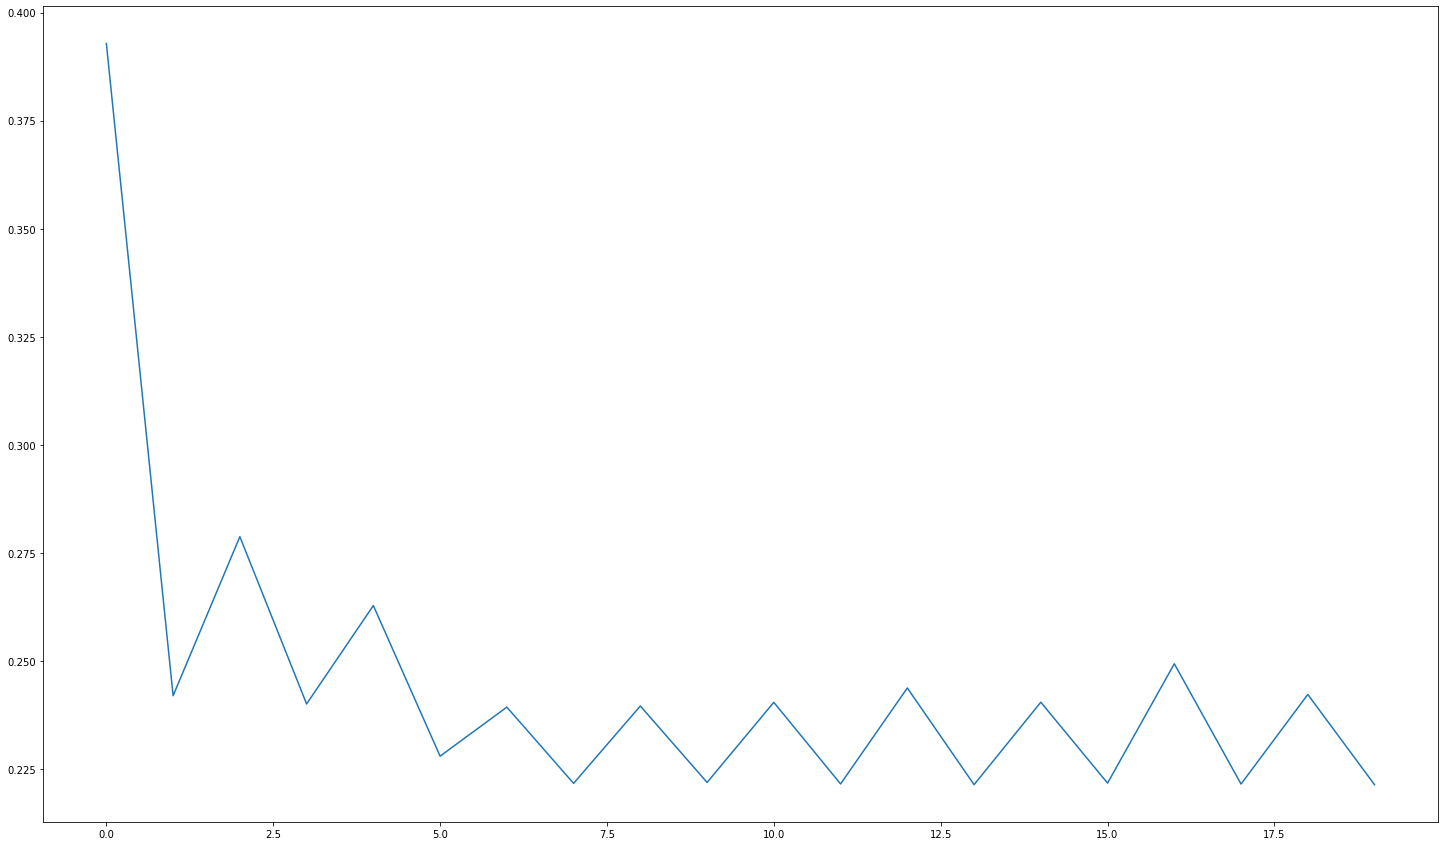

In [145]:
fig, ax = plt.subplots(len(nets),figsize=[25,15])
for i, ls in enumerate(vals):
    ax.plot(ls[2])
plt.show()

NameError: name 'signal' is not defined

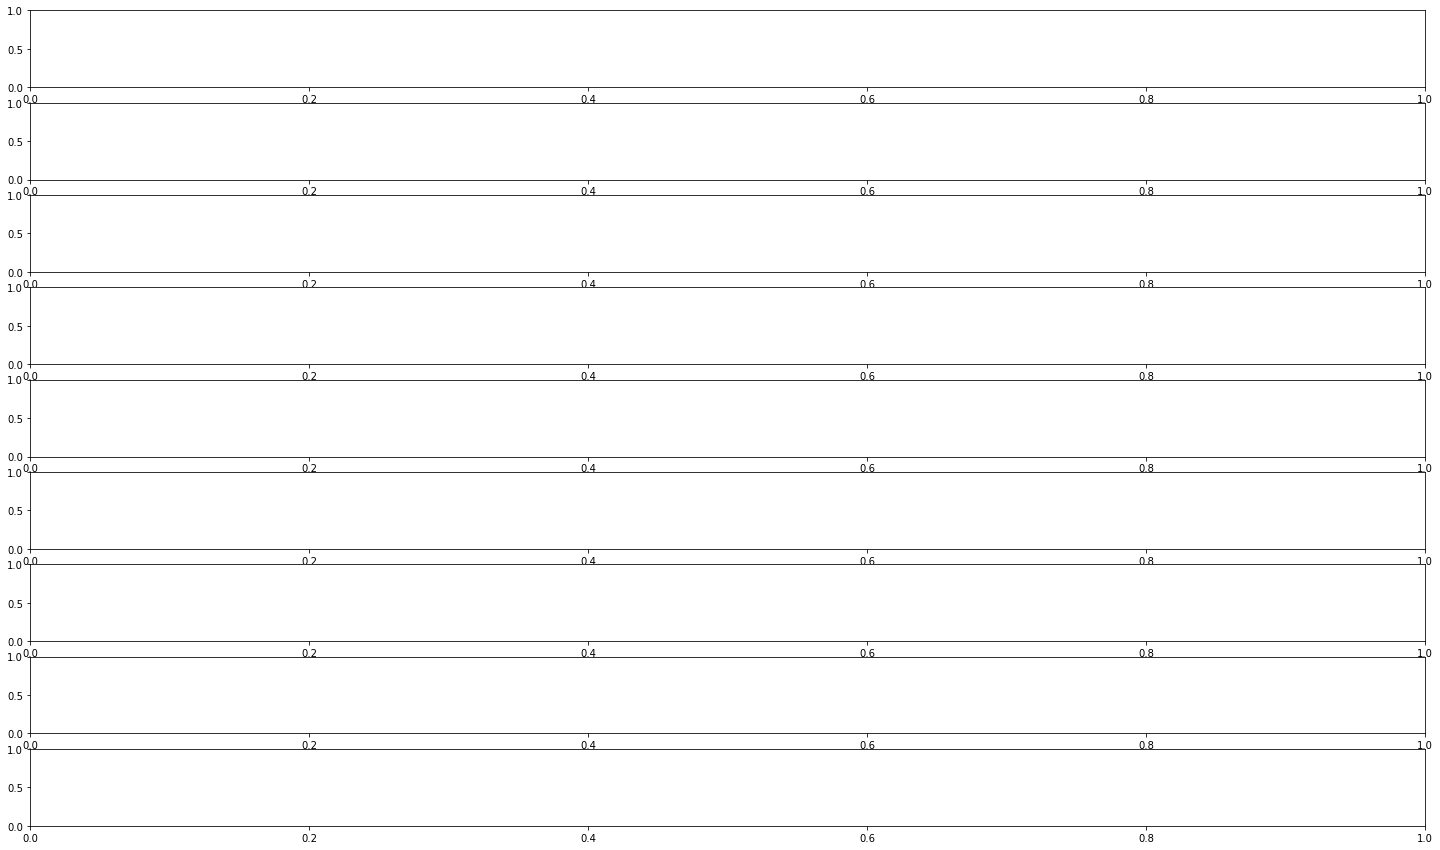

In [144]:
fig, ax = plt.subplots(len(num_hid)*len(lay),figsize=[25,15])
for i, ls in enumerate(vals):
    ax[i].plot(range(len(ls[2])), signal.savgol_filter(ls[2],5,1))
plt.show()

In [146]:
trn_it = iter(trn_dl)
batch, ys = next(trn_it)
# batch = np.reshape(batch,(10,5))
batch = batch.type(dtype)
ys = ys.type(dtype)
for net in nets:
    pred = net(batch)
    print(pred)
print(ys)

tensor([0.3104, 0.2891, 0.3110, 0.2958, 0.2961, 0.3061, 0.3197, 0.2928, 0.3063,
        0.3013], grad_fn=<TanhBackward>)
tensor([[0.7360],
        [0.6426],
        [0.0961],
        [0.0445],
        [0.6104],
        [0.1313],
        [0.1525],
        [0.7034],
        [0.0432],
        [0.0128]])


In [177]:
vls = []
for i, net in enumerate(nets):
    val_it = iter(val_dl)
    v = []
    v_ys = []
    net.eval()
    for batch in range(len(val_dl)):
        with torch.no_grad():
            v_bat, v_y = next(val_it)
#             v_bat = np.reshape(v_bat,(-1))
#             v_y = np.reshape(v_y,(-1))
            v_bat = v_bat.type(dtype)

            v.append(net(v_bat)[0].item())
            v_ys.append(v_y)
    vls.append(zip([v,v_ys]))

In [183]:
v = [vl for vl in v]
v_ys = [vl for ls in v_ys for vl in ls]

In [184]:
v_ys

[tensor([0.5174], dtype=torch.float64),
 tensor([0.1851], dtype=torch.float64),
 tensor([0.0053], dtype=torch.float64),
 tensor([0.5059], dtype=torch.float64),
 tensor([0.0855], dtype=torch.float64),
 tensor([0.0339], dtype=torch.float64),
 tensor([0.0031], dtype=torch.float64),
 tensor([0.0815], dtype=torch.float64),
 tensor([0.2146], dtype=torch.float64),
 tensor([0.7052], dtype=torch.float64),
 tensor([0.5364], dtype=torch.float64),
 tensor([0.1842], dtype=torch.float64),
 tensor([0.1551], dtype=torch.float64),
 tensor([0.6461], dtype=torch.float64),
 tensor([0.0903], dtype=torch.float64),
 tensor([0.0507], dtype=torch.float64),
 tensor([0.5086], dtype=torch.float64),
 tensor([0.5029], dtype=torch.float64),
 tensor([0.0013], dtype=torch.float64),
 tensor([0.2874], dtype=torch.float64),
 tensor([0.2772], dtype=torch.float64),
 tensor([0.5540], dtype=torch.float64),
 tensor([0.4059], dtype=torch.float64),
 tensor([0.5694], dtype=torch.float64),
 tensor([0.4976], dtype=torch.float64),


ValueError: Input could not be cast to an at-least-1D NumPy array

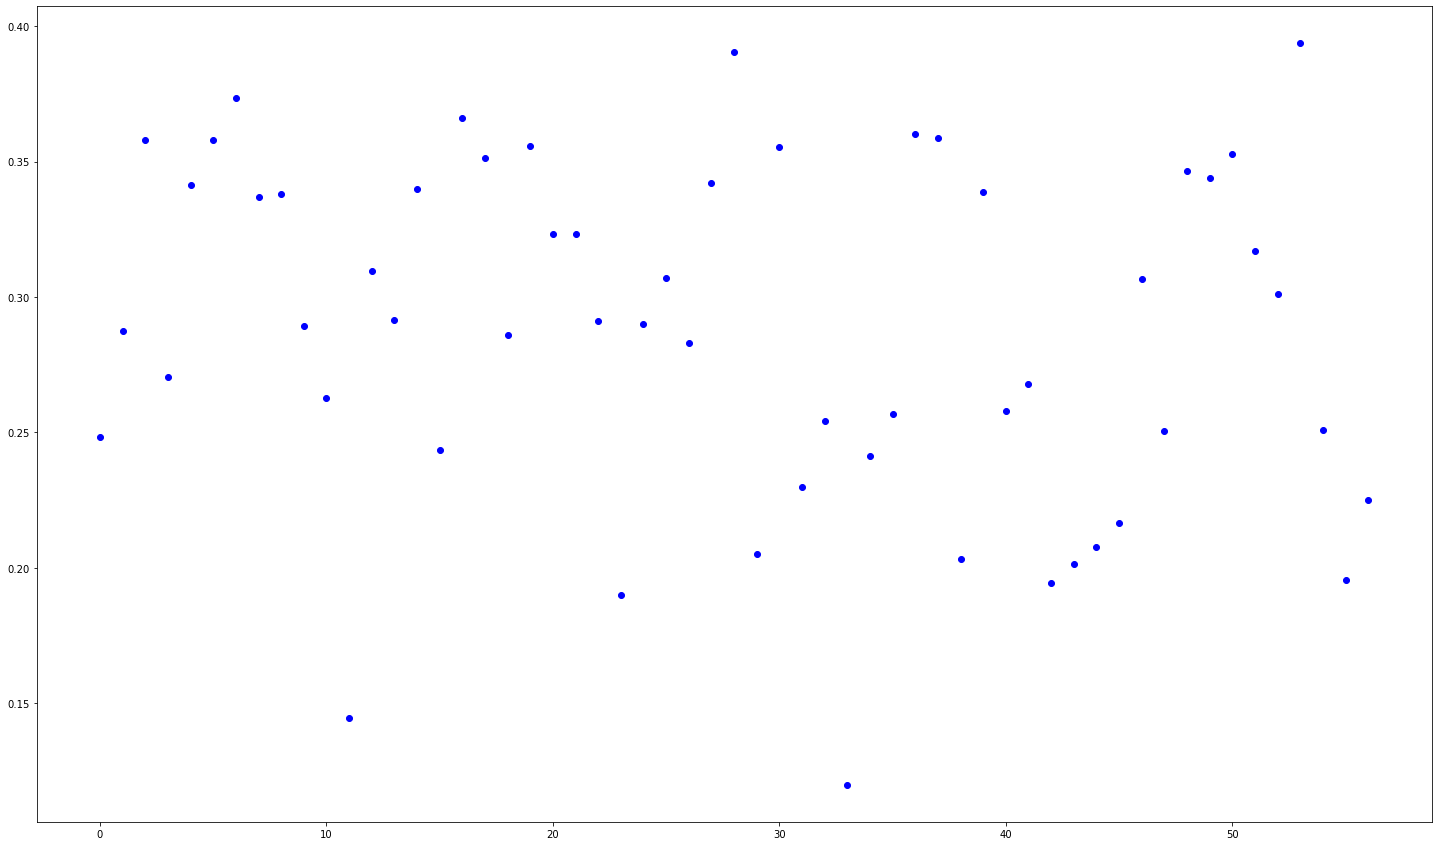

In [181]:
fig, ax = plt.subplots(len(nets),figsize=[25,15])
ax.plot(v,'bo')
ax.plot(v_ys,'ro')
plt.show()

In [ ]:
fig, ax = plt.subplots(len(nets),figsize=[25,15])
for i, ls in enumerate(vls):
    ax[i].plot(ls[0],'bo')
    ax[i].plot(ls[1],'ro')
plt.show()

In [ ]:
fig, ax = plt.subplots(2, figsize=[25,15])
for i, ls in enumerate(vls[-3:-1]):
    ax[i].plot(ls[0],'bo')
#     ax[i].plot(ls[1],'ro')
plt.show()

In [ ]:
print(nets[-2])

Reference


https://towardsdatascience.com/how-to-use-deep-learning-for-time-series-forecasting-3f8a399cf205

In [ ]:
torch.save(net.state_dict(),DATAPATH / 'checks' / f'lin_{lay}_balanced.pt')